In [3]:
import sys
sys.path.append("../")

from pathlib import Path

import jax
import jax.numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy.interpolate import interp1d
from scipy.stats import chi2

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
from matplotlib import cm
cmap = cm.get_cmap('viridis_r')

import matplotlib.pylab as pylab
import warnings
import matplotlib.cbook

from plot_params import params

warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

import logging
import matplotlib

logging.getLogger('matplotlib').setLevel(logging.ERROR)

## Runs

Likelihood profiles computed on cluster by running
```
cd scripts/
sbatch submit_infer.sh
```
which calls `infer.py` for each of the two runs.

## Load runs

In [12]:
# Load LL profiles for GNN position-only run

run_name = "gallant-cherry-87"
path_to_profiles = Path(f"/n/holystore01/LABS/iaifi_lab/Lab/set-diffuser-checkpoints/cosmology/{run_name}/ll_profiles/")

log_like_cov = []
log_like_cov_s8 = []

for i in range(4):
    ll_profs_npz = np.load(path_to_profiles / f"log_like_cov_v2_{i}.npz")
    log_like_cov.append(ll_profs_npz['log_like_cov'])
    log_like_cov_s8.append(ll_profs_npz['log_like_cov_s8'])

log_like_cov = np.mean(np.array(log_like_cov), axis=0)
log_like_cov_s8 = np.mean(np.array(log_like_cov_s8), axis=0)
conditioning = ll_profs_npz['conditioning']

sigma_8_ary = ll_profs_npz['sigma_8_ary']
omega_m_ary = ll_profs_npz['omega_m_ary']

In [22]:
# Load LL profiles for transormer all-features run

run_name = "magical-goosebump-109"
path_to_profiles = Path(f"/n/holystore01/LABS/iaifi_lab/Lab/set-diffuser-checkpoints/cosmology/{run_name}/ll_profiles/")

log_like_cov_vel = []
log_like_cov_vel_s8 = []

for i in range(4):
    ll_profs_vel_npz = np.load(path_to_profiles / f"log_like_cov_v2_{i}.npz")
    log_like_cov_vel.append(ll_profs_vel_npz['log_like_cov'])
    log_like_cov_vel_s8.append(ll_profs_vel_npz['log_like_cov_s8'])

log_like_cov_vel = np.mean(np.array(log_like_cov_vel), axis=0)
log_like_cov_vel_s8 = np.mean(np.array(log_like_cov_vel_s8), axis=0)
conditioning_vel = ll_profs_npz['conditioning']

sigma_8_vel_ary = ll_profs_vel_npz['sigma_8_ary']
omega_m_vel_ary = ll_profs_vel_npz['omega_m_ary']

## Plot

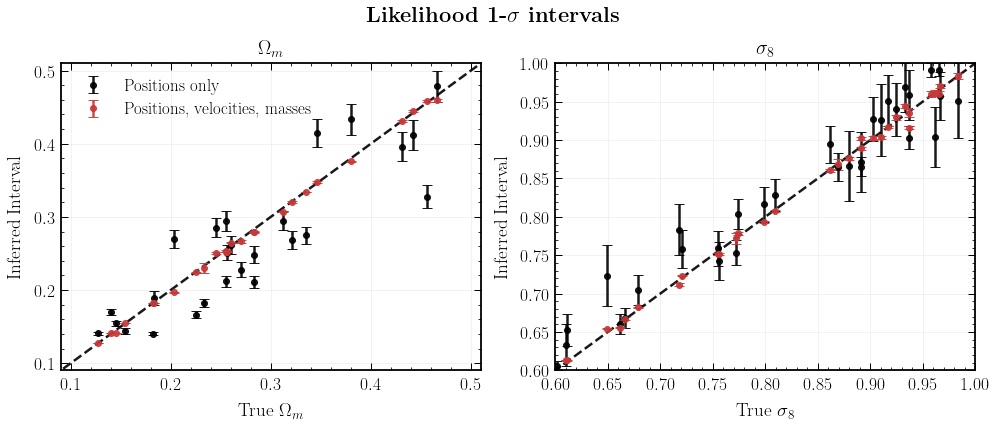

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

### Positions

i_ = 0
n_test_max = 32
threshold_1sigma = -chi2.isf(1 - .68, 1)

## Omega_m

intervals1 = []  # store intervals here
true_values = []  # store true values here

for ic, idx in enumerate(range(i_, i_ + n_test_max)):
    if conditioning[idx][0] < 0.12 or conditioning[idx][0] > 0.48:
        continue
        
    likelihood_arr = 2 * (np.array(log_like_cov[idx]) - np.max(np.array(log_like_cov[idx])))

    # Interpolate to find the 95% limits
    f_interp1 = interp1d(omega_m_ary, likelihood_arr - threshold_1sigma, kind='linear', fill_value="extrapolate")
    x_vals = np.linspace(omega_m_ary[0], omega_m_ary[-1], 1000)
    diff_signs1 = np.sign(f_interp1(x_vals))

    # Find where the sign changes
    sign_changes1 = ((diff_signs1[:-1] * diff_signs1[1:]) < 0).nonzero()[0]

    if len(sign_changes1) >= 2:  # We need at least two crossings
        intervals1.append((x_vals[sign_changes1[0]], x_vals[sign_changes1[-1]]))
        true_values.append(conditioning[idx][0])
    else:
        # Handle the case where no interval is found

        if x_vals[sign_changes1[0]] > 0.3:
            intervals1.append((x_vals[sign_changes1[0]], omega_m_ary[-1]))
            true_values.append(conditioning[idx][0])
        else:
            intervals1.append((omega_m_ary[0], x_vals[sign_changes1[0]]))
            true_values.append(conditioning[idx][0])
        
for idx, (value, (low, high)) in enumerate(zip(true_values, intervals1)):
    ax1.errorbar(value, (low + high) / 2., yerr=[[(low + high) / 2. - low], [high - (low + high) / 2.]], fmt='o', capsize=5, color='k', label="Positions only" if idx == 0 else None)

ax1.plot([0,1],[0,1], color='k', ls='--')

ax1.set_xlim(0.09, 0.51)
ax1.set_ylim(0.09, 0.51)

ax1.set_title("$\Omega_m$", y=1.01, fontsize=20)

ax1.set_xlabel("True $\Omega_m$")
ax1.set_ylabel("Inferred Interval")

## Sigma_8

intervals1 = []  # store intervals here
true_values = []  # store true values here

for ic, idx in enumerate(range(i_, i_ + n_test_max)):
    
    likelihood_arr = 2 * (np.array(log_like_cov_s8[idx]) - np.max(np.array(log_like_cov_s8[idx])))

    # Interpolate to find the 95% limits
    f_interp1 = interp1d(sigma_8_ary, likelihood_arr - threshold_1sigma, kind='linear', fill_value="extrapolate")
    x_vals = np.linspace(sigma_8_ary[0], sigma_8_vel_ary[-1], 1000)
    diff_signs1 = np.sign(f_interp1(x_vals))

    # Find where the sign changes
    sign_changes1 = ((diff_signs1[:-1] * diff_signs1[1:]) < 0).nonzero()[0]

    if len(sign_changes1) >= 2:  # We need at least two crossings
        intervals1.append((x_vals[sign_changes1[0]], x_vals[sign_changes1[-1]]))
        true_values.append(conditioning[idx][1])
    else:
        # Optionally handle the case where no interval is found
        
        if x_vals[sign_changes1[0]] > 0.8:
            intervals1.append((x_vals[sign_changes1[0]], sigma_8_ary[-1]))
            true_values.append(conditioning[idx][1])
        else:
            intervals1.append((sigma_8_ary[0], x_vals[sign_changes1[0]]))
            true_values.append(conditioning[idx][1])

for value, (low, high) in zip(true_values, intervals1):
    ax2.errorbar(value, (low + high) / 2., yerr=[[(low + high) / 2. - low], [high - (low + high) / 2.]], fmt='o', capsize=5, color='k')

ax2.plot([0,1],[0,1], color='k', ls='--')

ax2.set_xlim(0.6, 1.0)
ax2.set_ylim(0.6, 1.0)

ax2.set_title("$\sigma_8$", y=1.01, fontsize=20)

ax2.set_xlabel("True $\sigma_8$")
ax2.set_ylabel("Inferred Interval")

### Velocities

## Omega_m

intervals1 = []  # store intervals here
true_values = []  # store true values here

for ic, idx in enumerate(range(i_, i_ + n_test_max)):
    if conditioning[idx][0] < 0.12 or conditioning[idx][0] > 0.48:
        continue
        
    likelihood_arr = 2 * (np.array(log_like_cov_vel[idx]) - np.max(np.array(log_like_cov_vel[idx])))

    # Interpolate to find the 95% limits
    f_interp1 = interp1d(omega_m_vel_ary, likelihood_arr - threshold_1sigma, kind='linear', fill_value="extrapolate")
    x_vals = np.linspace(omega_m_vel_ary[0], omega_m_vel_ary[-1], 1000)
    diff_signs1 = np.sign(f_interp1(x_vals))

    # Find where the sign changes
    sign_changes1 = ((diff_signs1[:-1] * diff_signs1[1:]) < 0).nonzero()[0]

    if len(sign_changes1) >= 2:  # We need at least two crossings
        intervals1.append((x_vals[sign_changes1[0]], x_vals[sign_changes1[-1]]))
        true_values.append(conditioning_vel[idx][0])
    else:
        # Handle the case where no interval is found

        if len(sign_changes1) == 1:
            if x_vals[sign_changes1[0]] > 0.3:
                intervals1.append((x_vals[sign_changes1[0]], omega_m_vel_ary[-1]))
                true_values.append(conditioning_vel[idx][0])
            else:
                intervals1.append((omega_m_vel_ary[0], x_vals[sign_changes1[0]]))
                true_values.append(conditioning_vel[idx][0])
        else:
            pass
            
for idx, (value, (low, high)) in enumerate(zip(true_values, intervals1)):
    ax1.errorbar(value, (low + high) / 2., yerr=[[(low + high) / 2. - low], [high - (low + high) / 2.]], fmt='o', capsize=5, color=cols_default[0], label="Positions, velocities, masses" if idx == 0 else None)


## Sigma_8

intervals1 = []  # store intervals here
true_values = []  # store true values here

for ic, idx in enumerate(range(i_, i_ + n_test_max)):
    
    likelihood_arr = 2 * (np.array(log_like_cov_vel_s8[idx]) - np.max(np.array(log_like_cov_vel_s8[idx])))

    # Interpolate to find the 95% limits
    f_interp1 = interp1d(sigma_8_vel_ary, likelihood_arr - threshold_1sigma, kind='linear', fill_value="extrapolate")
    x_vals = np.linspace(sigma_8_vel_ary[0], sigma_8_vel_ary[-1], 1000)
    diff_signs1 = np.sign(f_interp1(x_vals))

    # Find where the sign changes
    sign_changes1 = ((diff_signs1[:-1] * diff_signs1[1:]) < 0).nonzero()[0]

    if len(sign_changes1) >= 2:  # We need at least two crossings
        intervals1.append((x_vals[sign_changes1[0]], x_vals[sign_changes1[-1]]))
        true_values.append(conditioning_vel[idx][1])
    else:
        # Optionally handle the case where no interval is found
        pass

for value, (low, high) in zip(true_values, intervals1):
    ax2.errorbar(value, (low + high) / 2., yerr=[[(low + high) / 2. - low], [high - (low + high) / 2.]], fmt='o', capsize=5, color=cols_default[0])

plt.suptitle(r"\bf{Likelihood 1-$\sigma$ intervals}", fontsize=22)

ax1.grid(True, alpha=0.2)
ax2.grid(True, alpha=0.2)

ax1.legend(loc='upper left')

plt.tight_layout()
# plt.savefig("plots/ll_prof.pdf")